## Online Retail Case

### Unsupervised Learning: Clustering

In [1]:
#Import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from yellowbrick.cluster import SilhouetteVisualizer
from math import pi

import scipy.cluster.hierarchy as shc

### **I. Data Preparation**
#### a. Load the dataset and conduct an initial exploration of the data.

In [2]:
#Load dataset
df = pd.read_excel('Online Retail.xlsx')

pd.set_option('display.max_columns', None)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
#Explore the dataset
print(f'Dataset Shape: {df.shape}')
print('\nSummary of the Data Set:')
df.info()

print(f'\nSummary Statistics for Numerical Columns:')
df.describe()

Dataset Shape: (541909, 8)

Summary of the Data Set:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB

Summary Statistics for Numerical Columns:


,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [4]:
#Check missing values and duplicate rows
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})

print(f'Missing values in each column: \n{missing_df}')

print(f'\nNumber of duplicate rows: {df.duplicated().sum()}')

Missing values in each column: 
             Missing Values  Percentage
InvoiceNo                 0    0.000000
StockCode                 0    0.000000
Description            1454    0.268311
Quantity                  0    0.000000
InvoiceDate               0    0.000000
UnitPrice                 0    0.000000
CustomerID           135080   24.926694
Country                   0    0.000000

Number of duplicate rows: 5268


Count of unique countries: 38

 Country
United Kingdom          495478
Germany                   9495
France                    8557
EIRE                      8196
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               2002
Portugal                  1519
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Unspecified                446
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61

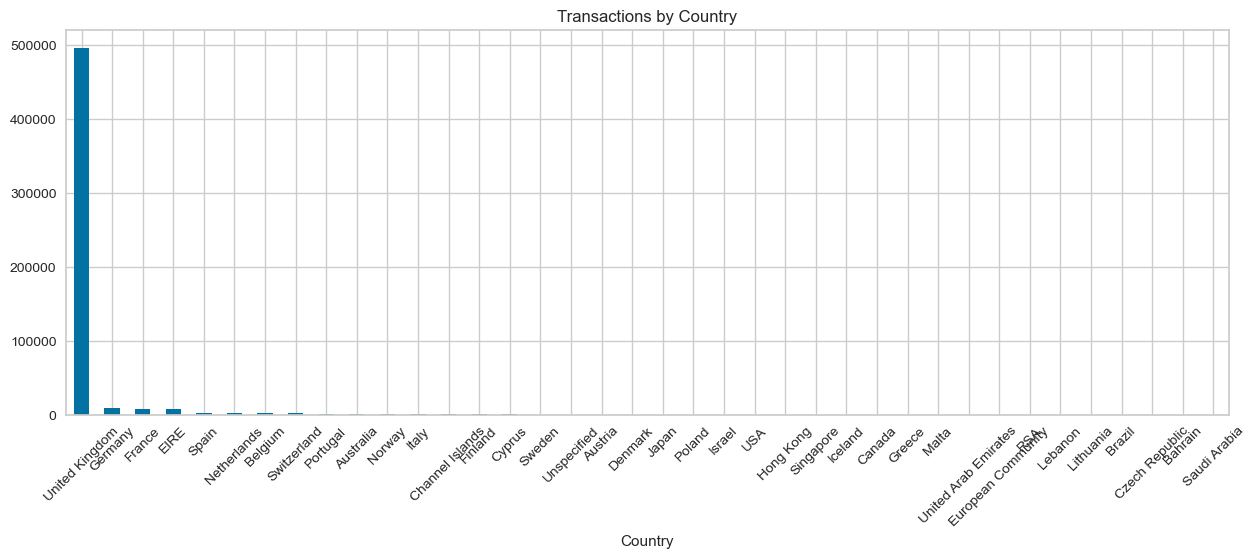

In [5]:
#Check spread of countries
print(f'Count of unique countries: {df['Country'].nunique()}')

print(f"\n {df['Country'].value_counts()}")

df['Country'].value_counts().plot(kind='bar', figsize=(15, 5))
plt.title('Transactions by Country')
plt.xticks(rotation=45)
plt.show()

In [6]:
#Check transaction time span
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
print(f"Transaction Time Span: {df['InvoiceDate'].min()} to {df['InvoiceDate'].max()}")

Transaction Time Span: 2010-12-01 08:26:00 to 2011-12-09 12:50:00


count    4372.000000
mean        5.075480
std         9.338754
min         1.000000
25%         1.000000
50%         3.000000
75%         5.000000
max       248.000000
Name: InvoiceNo, dtype: float64


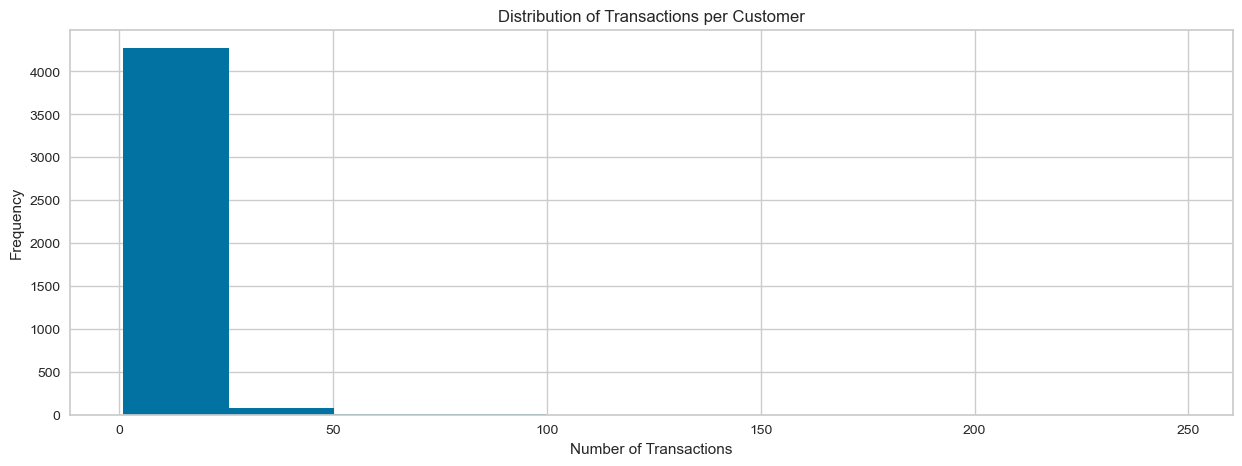

In [7]:
#Exploring customer behavior

transactions_per_customer = df.groupby('CustomerID')['InvoiceNo'].nunique()
print(transactions_per_customer.describe()) 

transactions_per_customer.plot(kind='hist', figsize=(15, 5))
plt.title('Distribution of Transactions per Customer')
plt.xlabel('Number of Transactions')
plt.ylabel('Frequency')
plt.show()

count     25900.000000
mean        376.360924
std        2013.261050
min     -168469.600000
25%          11.775000
50%         207.535000
75%         409.085000
max      168469.600000
Name: TotalAmount, dtype: float64


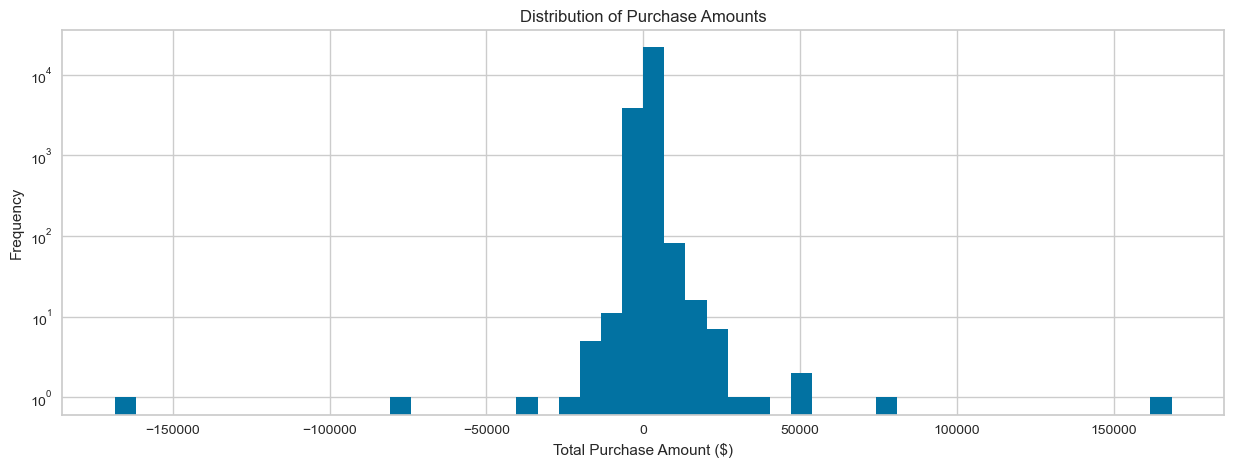

In [8]:
#Total purchase amount per invoice
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']
purchase_amounts = df.groupby('InvoiceNo')['TotalAmount'].sum()

print(purchase_amounts.describe())

purchase_amounts.plot(kind='hist', bins=50, figsize=(15, 5), log=True)
plt.title('Distribution of Purchase Amounts')
plt.xlabel('Total Purchase Amount ($)')
plt.ylabel('Frequency')
plt.show()


In [9]:
#Check transactions with negative quantities and prices - potentially returns or cancelations
negative_quantity = df[df['Quantity'] < 0]
print(f'Rows with negative quantity: {negative_quantity.shape[0]}')
print(negative_quantity[['InvoiceNo', 'StockCode', 'Quantity', 'CustomerID']].head())

negative_price = df[df['UnitPrice'] <= 0]
print(f'\n Rows with zero or negative unit price: {negative_price.shape[0]}')
print(negative_price[['InvoiceNo', 'StockCode', 'UnitPrice', 'CustomerID']].head())

Rows with negative quantity: 10624
    InvoiceNo StockCode  Quantity  CustomerID
141   C536379         D        -1     14527.0
154   C536383    35004C        -1     15311.0
235   C536391     22556       -12     17548.0
236   C536391     21984       -24     17548.0
237   C536391     21983       -24     17548.0

 Rows with zero or negative unit price: 2517
     InvoiceNo StockCode  UnitPrice  CustomerID
622     536414     22139        0.0         NaN
1970    536545     21134        0.0         NaN
1971    536546     22145        0.0         NaN
1972    536547     37509        0.0         NaN
1987    536549    85226A        0.0         NaN


StockCode
85123A    2313
22423     2203
85099B    2159
47566     1727
20725     1639
84879     1502
22720     1477
22197     1476
21212     1385
20727     1350
Name: count, dtype: int64


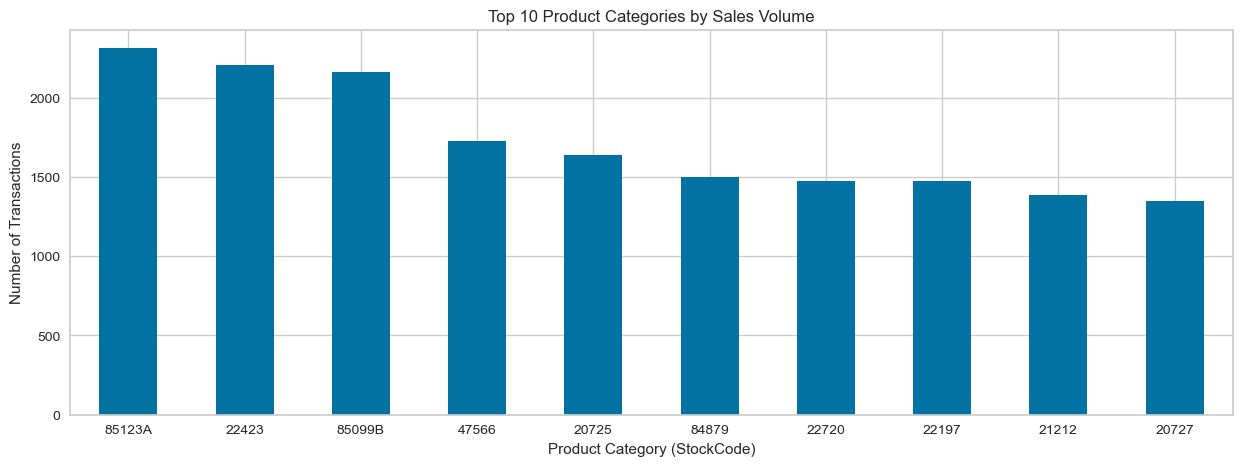

In [10]:
#Explore top product category purchases
category_counts = df['StockCode'].value_counts()

print(category_counts.head(10))

category_counts.head(10).plot(kind='bar', figsize=(15, 5))
plt.title('Top 10 Product Categories by Sales Volume')
plt.xlabel('Product Category (StockCode)')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=0)
plt.show()


#### b. Handle missing values appropriately.

In [11]:
#Remove transactions without CustomerID
df_clean = df.dropna(subset=['CustomerID'])

#Remove negative quantities and price
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] > 0)]

#Remove duplicate values
df_clean = df_clean.drop_duplicates().reset_index(drop=True)

print(f'Original dataset: {df.shape[0]} rows')
print(f'After removing missing values and negative quantities: {df_clean.shape[0]} rows')

df_clean['Description'] = df_clean['Description'].fillna("")
print(df_clean.isnull().sum())

df_clean.head()

Original dataset: 541909 rows
After removing missing values and negative quantities: 392692 rows
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
TotalAmount    0
dtype: int64


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


#### c. Feature creation and transformation

In [12]:
#Convert data types
df_clean['CustomerID'] = df_clean['CustomerID'].astype(int)
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['UnitPrice']
df_clean['Year'] = df_clean['InvoiceDate'].dt.year
df_clean['Month'] = df_clean['InvoiceDate'].dt.month
df_clean['Day'] = df_clean['InvoiceDate'].dt.day
df_clean['DayOfWeek'] = df_clean['InvoiceDate'].dt.dayofweek
df_clean['Hour'] = df_clean['InvoiceDate'].dt.hour

max_date = df_clean['InvoiceDate'].max()

#Create additional features 
customer_features = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': [lambda x: (max_date - x.max()).days,  
                    lambda x: (x.max() - x.min()).days],  
    'InvoiceNo': 'nunique',                             
    'TotalPrice': ['sum', 'mean', 'std'],              
    'Quantity': ['sum', 'mean', 'std'],
    'UnitPrice': ['mean', 'std'],
    'StockCode': 'nunique'                            
})

#Fix column names
customer_features.columns = ['_'.join(col).strip() for col in customer_features.columns.values]
customer_features.rename(columns={
    'InvoiceDate_<lambda_0>': 'Recency',
    'InvoiceDate_<lambda_1>': 'Customer_Lifetime',
    'InvoiceNo_nunique': 'Purchase_Frequency',
    'TotalPrice_sum': 'OrderSpend'
}, inplace=True)

#Calculate more features
customer_features['Purchase_Frequency_Rate'] = customer_features['Purchase_Frequency'] / \
                                               customer_features['Customer_Lifetime'].clip(lower=1)
customer_features['Avg_Items_per_Order'] = customer_features['Quantity_sum'] / \
                                           customer_features['Purchase_Frequency'].clip(lower=1)
customer_features['Avg_Spend_per_Order'] = customer_features['OrderSpend'] / \
                                          customer_features['Purchase_Frequency'].clip(lower=1)

#Assign 1 country (most frequent) per customer
customer_features['Country'] = df_clean.groupby('CustomerID')['Country'].agg(lambda x: x.mode()[0])

#Check missing values
print(customer_features.isna().sum())

customer_features = customer_features.reset_index()

customer_features.head()

Recency                     0
Customer_Lifetime           0
Purchase_Frequency          0
OrderSpend                  0
TotalPrice_mean             0
TotalPrice_std             71
Quantity_sum                0
Quantity_mean               0
Quantity_std               71
UnitPrice_mean              0
UnitPrice_std              71
StockCode_nunique           0
Purchase_Frequency_Rate     0
Avg_Items_per_Order         0
Avg_Spend_per_Order         0
Country                     0
dtype: int64


,CustomerID,Recency,Customer_Lifetime,Purchase_Frequency,OrderSpend,TotalPrice_mean,TotalPrice_std,Quantity_sum,Quantity_mean,Quantity_std,UnitPrice_mean,UnitPrice_std,StockCode_nunique,Purchase_Frequency_Rate,Avg_Items_per_Order,Avg_Spend_per_Order,Country
0,12346,325,0,1,77183.60,77183.600000,NaN,74215,74215.000000,NaN,1.040000,NaN,1,1.000000,74215.000000,77183.600000,United Kingdom
1,12347,1,365,7,4310.00,23.681319,23.289902,2458,13.505495,18.856172,2.644011,2.255381,103,0.019178,351.142857,615.714286,Iceland
2,12348,74,282,4,1797.24,57.975484,48.514857,2341,75.516129,51.091990,5.764839,13.400323,22,0.014184,585.250000,449.310000,Finland
3,12349,18,0,1,1757.55,24.076027,34.655913,631,8.643836,6.982856,8.289041,35.028021,73,1.000000,631.000000,1757.550000,Italy
4,12350,309,0,1,334.40,19.670588,7.275538,197,11.588235,4.345383,3.841176,9.334751,17,1.000000,197.000000,334.400000,Norway


In [13]:
#Handle missing values
customer_features['TotalPrice_std'] = customer_features['TotalPrice_std'].fillna('')
customer_features['Quantity_std'] = customer_features['Quantity_std'].fillna('')
customer_features['UnitPrice_std'] = customer_features['UnitPrice_std'].fillna('')
print(customer_features.isna().sum())

CustomerID                 0
Recency                    0
Customer_Lifetime          0
Purchase_Frequency         0
OrderSpend                 0
TotalPrice_mean            0
TotalPrice_std             0
Quantity_sum               0
Quantity_mean              0
Quantity_std               0
UnitPrice_mean             0
UnitPrice_std              0
StockCode_nunique          0
Purchase_Frequency_Rate    0
Avg_Items_per_Order        0
Avg_Spend_per_Order        0
Country                    0
dtype: int64


#### d. Analyze correlations between numerical features and select appropriate independent variables for the model

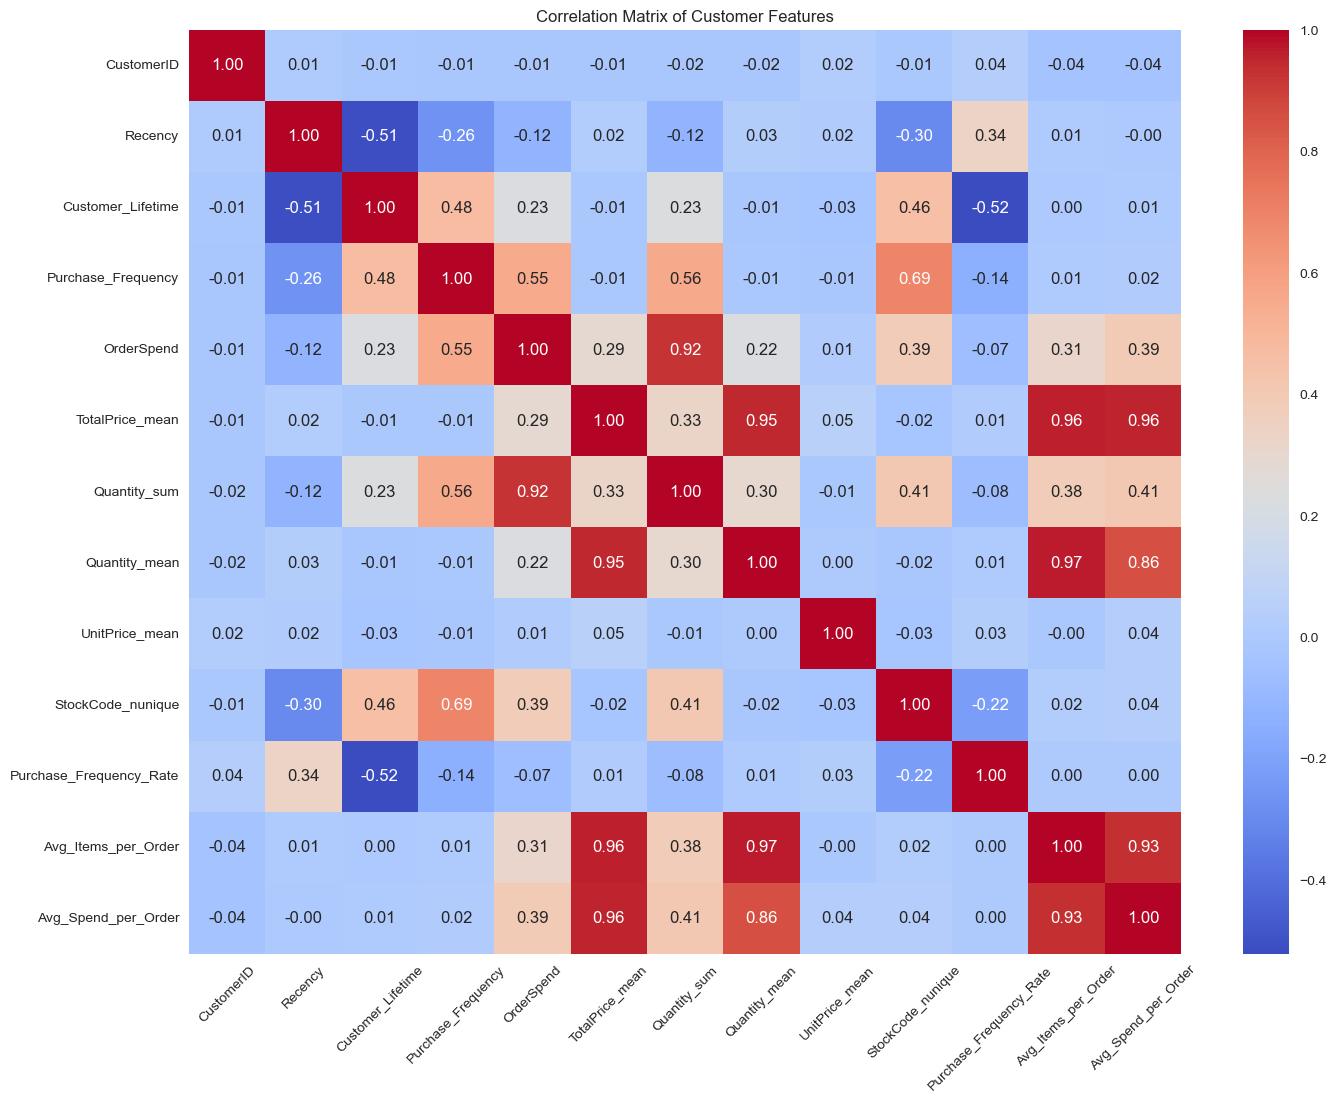

In [14]:
numerical_features = customer_features.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = customer_features[numerical_features].corr()

plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Customer Features')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [15]:
#Select features based on correlation matrix
clustering_features = [
    'Recency',                  
    'Customer_Lifetime',       
    'Purchase_Frequency',          
    'Avg_Spend_per_Order',    
    'StockCode_nunique',      
    'UnitPrice_mean'
]

#Create the feature dataset for clustering
X = customer_features[clustering_features].copy()

X.describe()


,Recency,Customer_Lifetime,Purchase_Frequency,Avg_Spend_per_Order,StockCode_nunique,UnitPrice_mean
count,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000
mean,91.536422,130.448594,4.272015,417.645735,61.501153,4.470820
std,100.014169,132.039554,7.697998,1796.511343,85.366768,34.215024
min,0.000000,0.000000,1.000000,3.450000,1.000000,0.122500
25%,17.000000,0.000000,1.000000,177.867083,16.000000,2.206415
50%,50.000000,92.500000,2.000000,291.940000,35.000000,2.917836
75%,141.000000,251.750000,5.000000,428.280625,77.000000,3.832541
max,373.000000,373.000000,209.000000,84236.250000,1787.000000,2033.100000


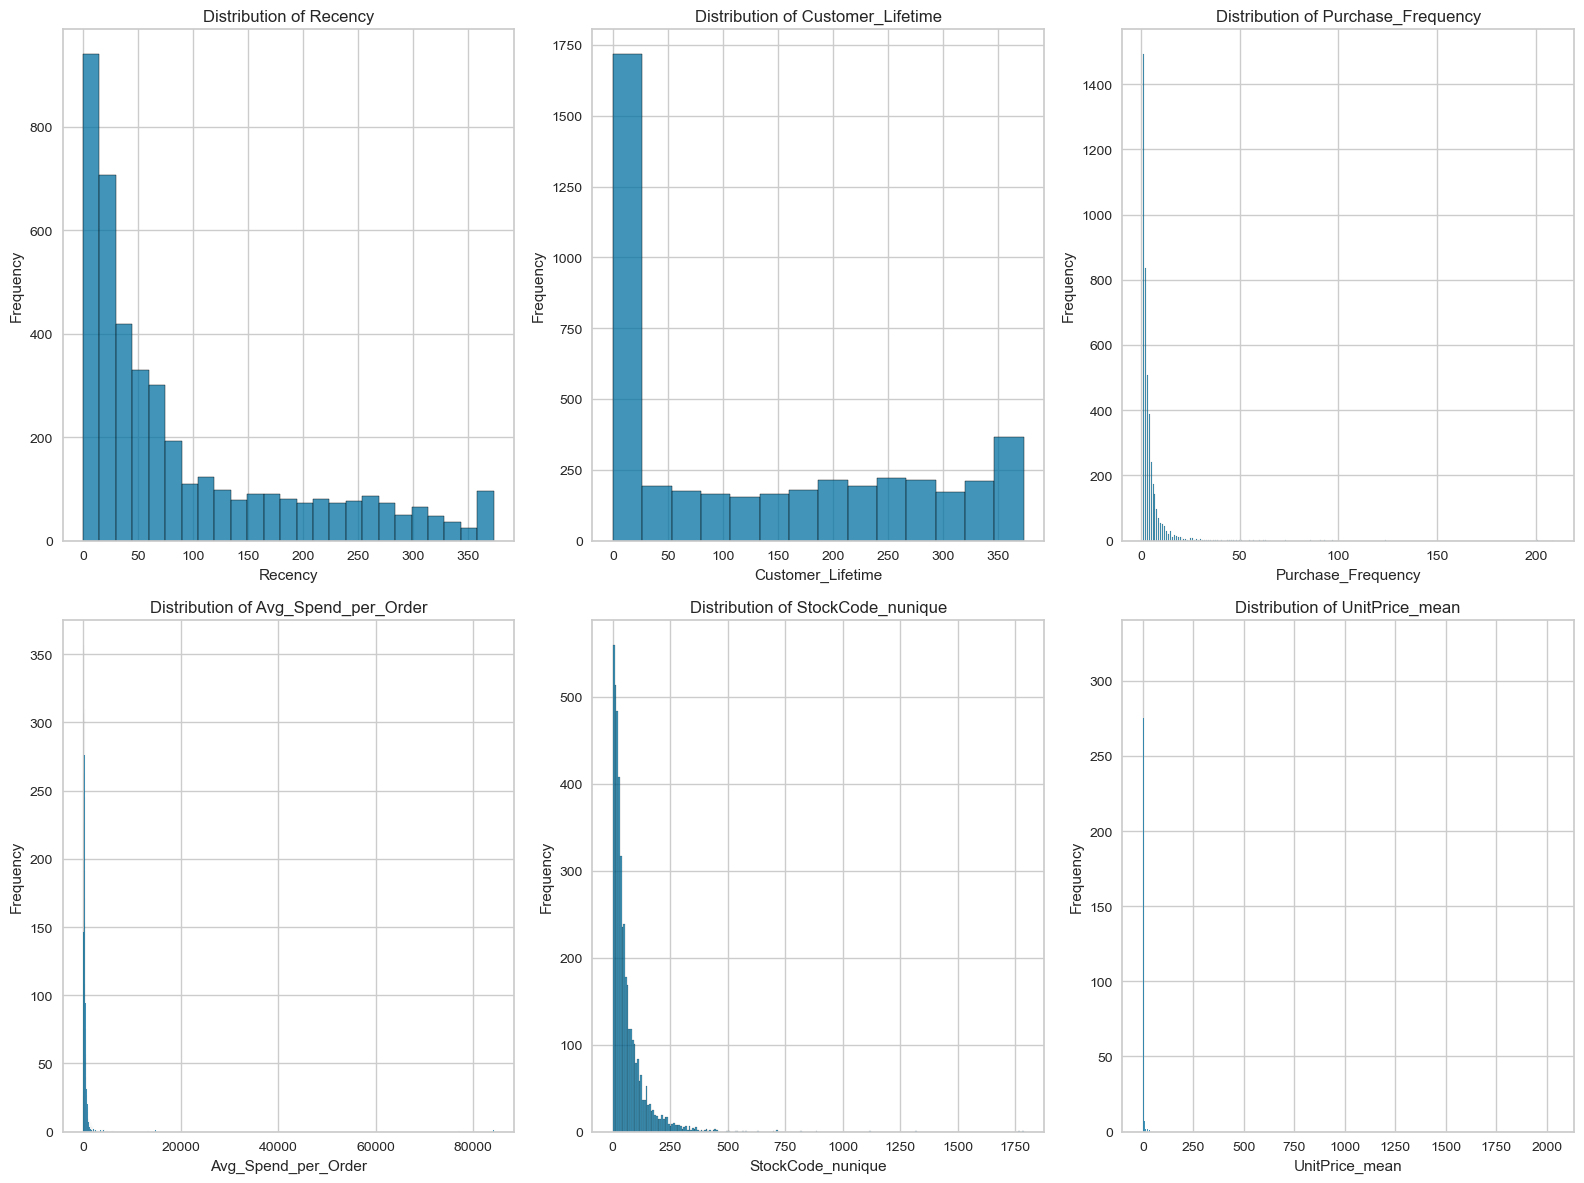

In [16]:
#Check distribution of selected features
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 12))
axes = axes.flatten()

for i, column in enumerate(clustering_features):
    if i < len(axes):
        sns.histplot(X[column], ax=axes[i])
        axes[i].set_title(f'Distribution of {column}')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

#### e. Apply necessary data transformations, such as normalization or standardization

<Figure size 1500x1000 with 0 Axes>

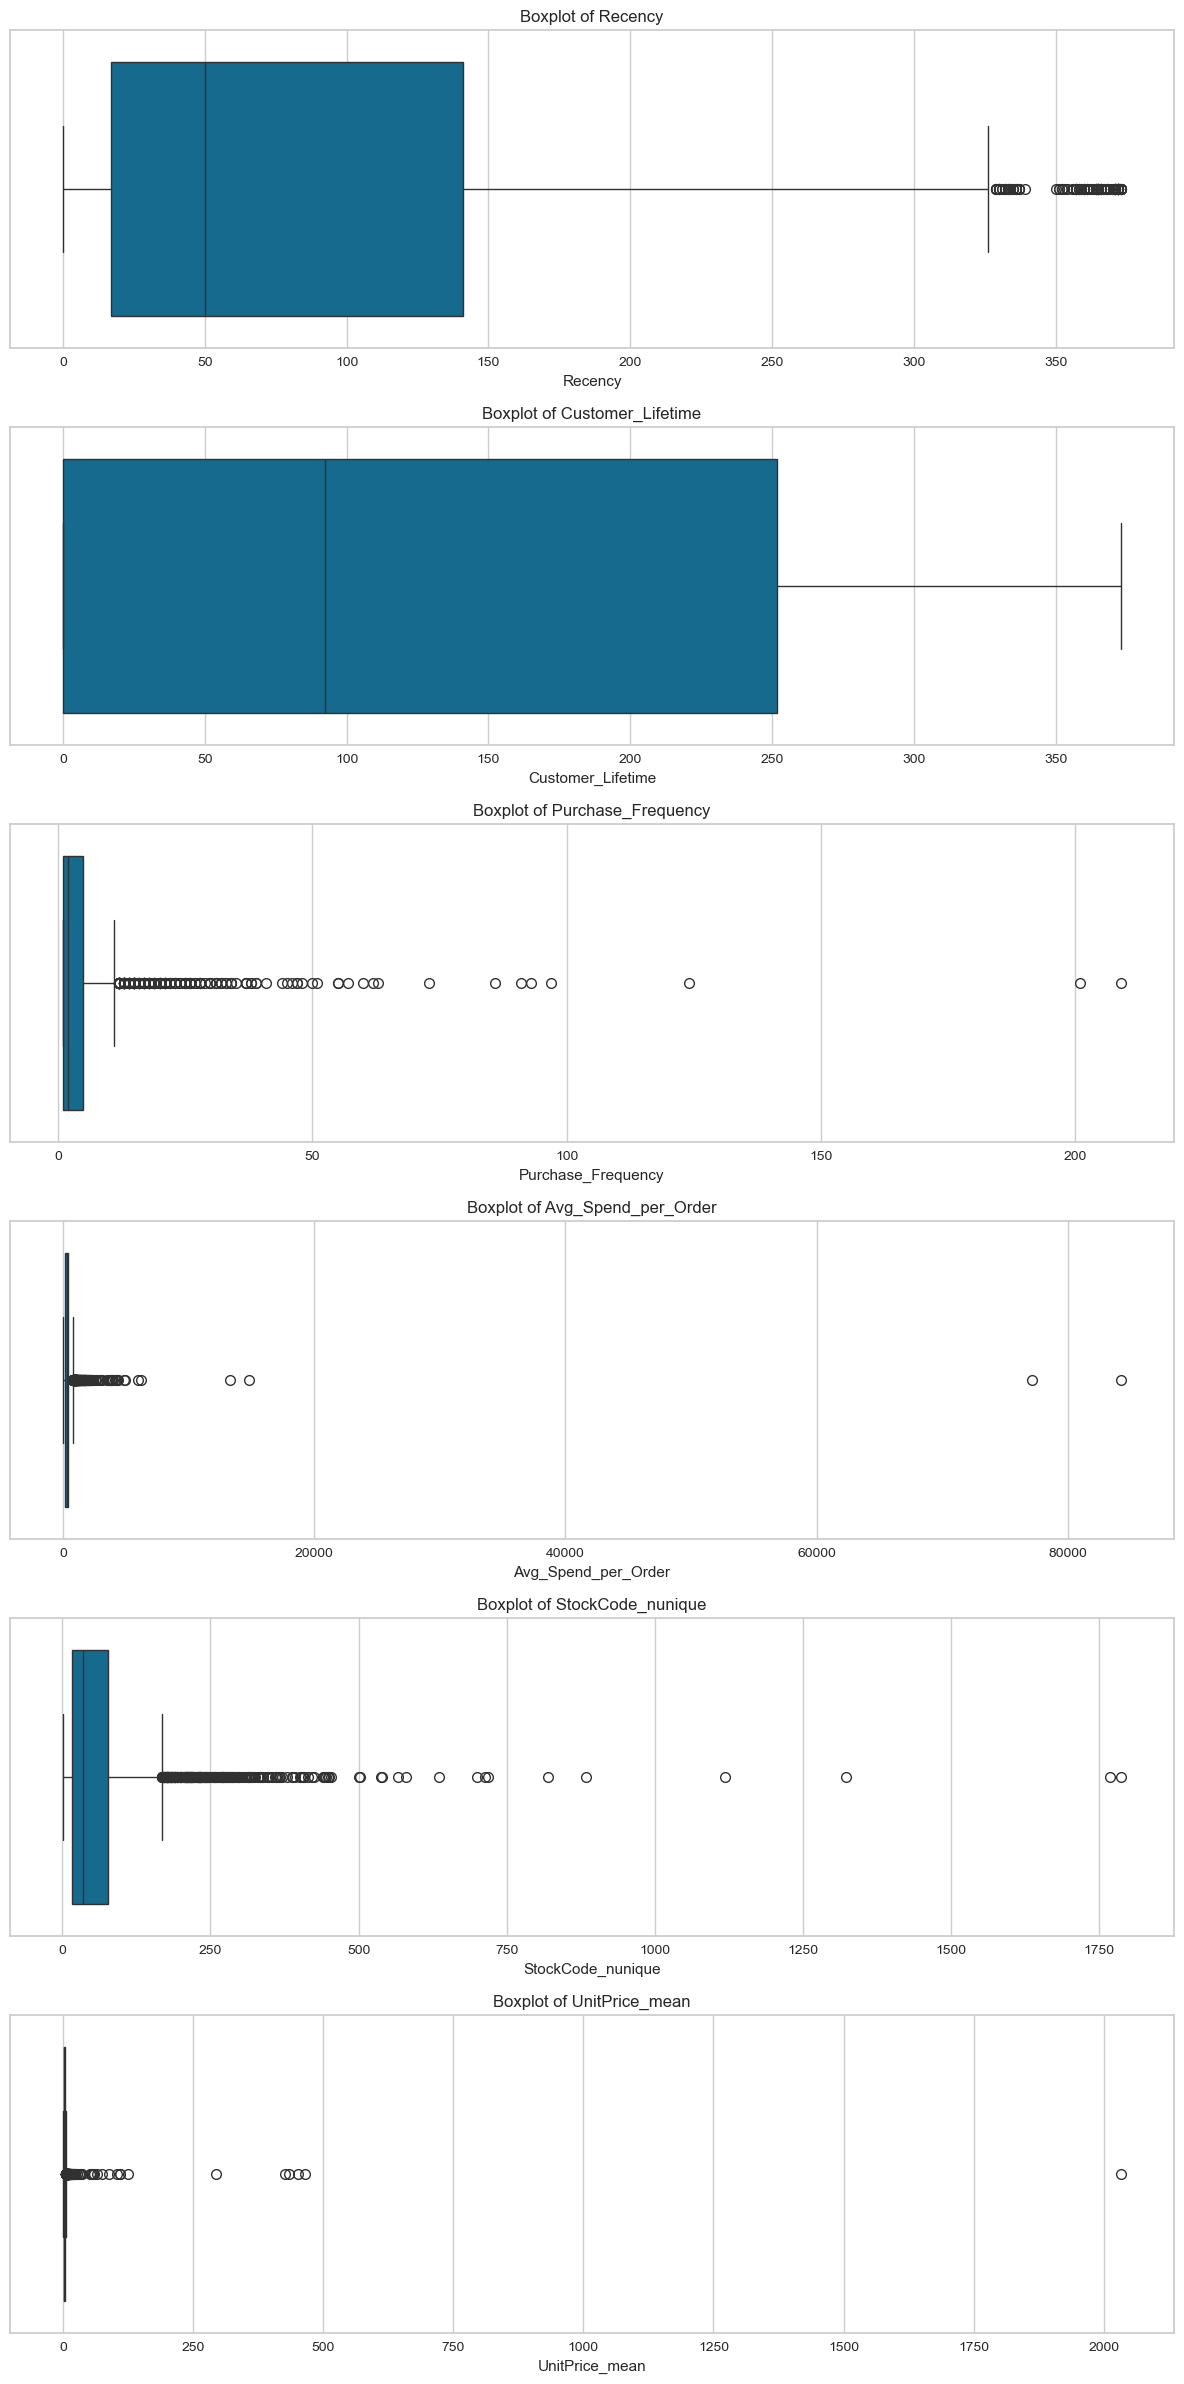

In [17]:
#Check for outliers
plt.figure(figsize=(15, 10))
fig, axes = plt.subplots(nrows=len(clustering_features), ncols=1, figsize=(12, 4*len(clustering_features)))

for i, feature in enumerate(clustering_features):
    sns.boxplot(x=customer_features[feature], ax=axes[i])
    axes[i].set_title(f'Boxplot of {feature}')
    axes[i].set_xlabel(feature)

plt.tight_layout()
plt.show()

Capped Recency: min=0.00, max=368.00
Capped Customer_Lifetime: min=0.00, max=367.00
Capped Purchase_Frequency: min=1.00, max=30.00
Capped Avg_Spend_per_Order: min=43.31, max=2031.16
Capped StockCode_nunique: min=1.00, max=354.00
Capped UnitPrice_mean: min=0.69, max=13.88


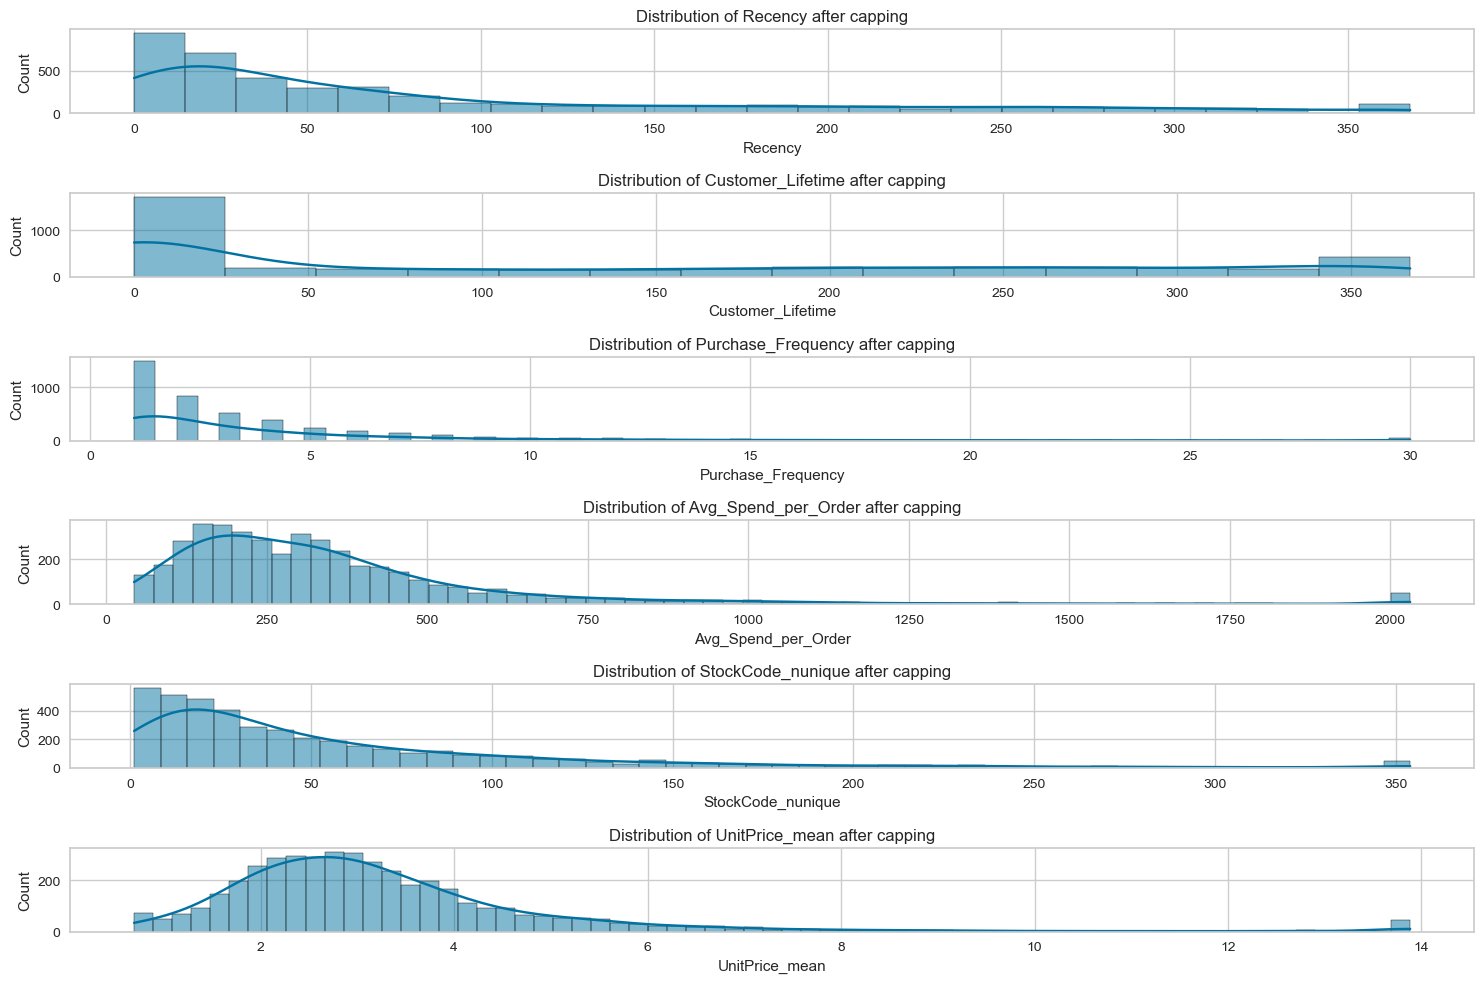

In [18]:
#Remove outliers
for col in X.columns:
    q1, q99 = X[col].quantile([0.01, 0.99])
    X[col] = X[col].clip(q1, q99)
    print(f"Capped {col}: min={q1:.2f}, max={q99:.2f}")

plt.figure(figsize=(15, 10))
for i, feature in enumerate(X.columns):
    plt.subplot(len(X.columns), 1, i+1)
    sns.histplot(X[feature], kde=True)
    plt.title(f'Distribution of {feature} after capping')
plt.tight_layout()
plt.show()

In [19]:
#Log transform
skewed_features = []
for feature in X.columns:
    skewness = X[feature].skew()
    print(f'Skewness of {feature}: {skewness:.2f}')
    if abs(skewness) > 1: 
        skewed_features.append(feature)
        
print(f'\nApplying log transformation to skewed features: {skewed_features}')
for feature in skewed_features:
    X[f'{feature}_log'] = np.log1p(X[feature])

Skewness of Recency: 1.24
Skewness of Customer_Lifetime: 0.45
Skewness of Purchase_Frequency: 3.05
Skewness of Avg_Spend_per_Order: 2.87
Skewness of StockCode_nunique: 2.18
Skewness of UnitPrice_mean: 2.76

Applying log transformation to skewed features: ['Recency', 'Purchase_Frequency', 'Avg_Spend_per_Order', 'StockCode_nunique', 'UnitPrice_mean']


In [20]:
#Prep final features
final_features = []
for feature in X.columns:
    if feature in skewed_features:
        final_features.append(f'{feature}_log')
    elif feature not in [f"{skewed}_log" for skewed in skewed_features]:
        final_features.append(feature)

print(f"\nFinal features for clustering: {final_features}")
X_final = X[final_features]


Final features for clustering: ['Recency_log', 'Customer_Lifetime', 'Purchase_Frequency_log', 'Avg_Spend_per_Order_log', 'StockCode_nunique_log', 'UnitPrice_mean_log']


In [21]:
X_transformed = X_final

preprocessing_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')), 
    ('normalizer', PowerTransformer(method='yeo-johnson')),
    ('scaler', RobustScaler())          
])

X_scaled = preprocessing_pipeline.fit_transform(X_transformed)
X_scaled_df = pd.DataFrame(X_scaled, columns=final_features, index=X_transformed.index)

for col in final_features:
    customer_features[f'{col}_scaled'] = X_scaled_df[col]

print(f'\nSummary of scaled features:')
X_scaled_df.describe()


Summary of scaled features:


,Recency_log,Customer_Lifetime,Purchase_Frequency_log,Avg_Spend_per_Order_log,StockCode_nunique_log,UnitPrice_mean_log
count,4338.000000,4.338000e+03,4338.000000,4.338000e+03,4338.000000,4.338000e+03
mean,-0.022595,-1.729331e-01,0.069234,-5.091871e-02,0.010098,-4.906167e-03
std,0.648074,4.572650e-01,0.481316,8.009195e-01,0.721175,8.590802e-01
min,-1.431440,-7.421467e-01,-0.500650,-2.243226e+00,-1.643509,-2.547306e+00
25%,-0.476513,-7.421467e-01,-0.500650,-5.677452e-01,-0.477645,-5.108992e-01
50%,0.000000,1.279359e-17,0.000000,5.556536e-18,0.000000,3.726945e-19
75%,0.523487,2.578533e-01,0.499350,4.322548e-01,0.522355,4.891008e-01
max,1.056609,3.676035e-01,1.028378,2.132014e+00,1.624311,2.558944e+00


### **II. Model Creation**
#### a. Choose and apply clustering algorithm

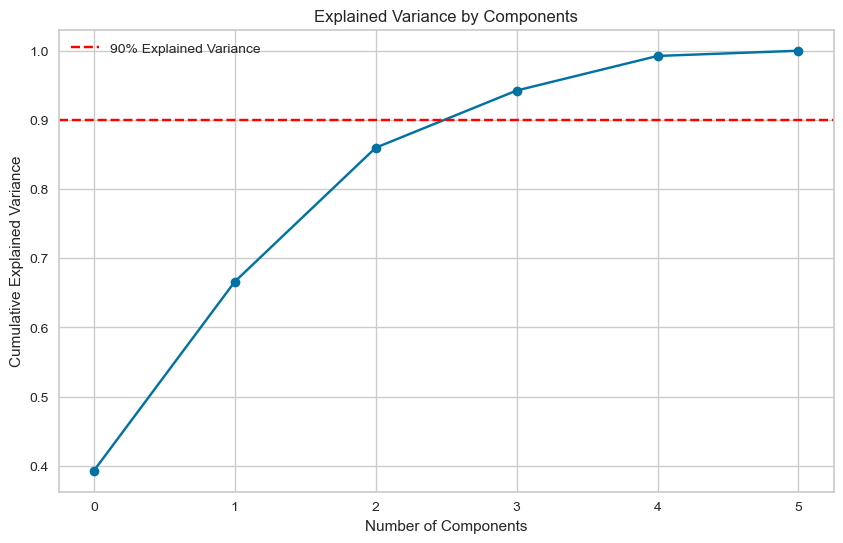

Explained variance ratio by 2 principal components: 0.67


In [22]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_df)
X_pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'], index=X_scaled_df.index)

# Plot explained variance
pca_full = PCA().fit(X_scaled_df)
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), marker='o')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.9, color='red', linestyle='--', label='90% Explained Variance')
plt.grid(True)
plt.legend()
plt.show()

print(f'Explained variance ratio by 2 principal components: {np.sum(pca.explained_variance_ratio_):.2f}')

In [23]:
#Feature importance
pca = PCA(n_components=6)
pca.fit(X_scaled_df)

loadings = pd.DataFrame(
    pca.components_.T, 
    index=X_scaled_df.columns, 
    columns=[f'PC{i+1}' for i in range(6)])

display(loadings)

important_features = loadings.iloc[:, :5].abs().sum(axis=1).sort_values(ascending=False)
print(f'\nFeature Importance Based on First 5 PCs:\n{important_features}')

,PC1,PC2,PC3,PC4,PC5,PC6
Recency_log,0.415691,0.100027,0.382517,-0.776547,0.258587,0.031358
Customer_Lifetime,-0.313467,0.004387,-0.279275,-0.138573,0.581964,-0.682525
Purchase_Frequency_log,-0.352154,0.005462,-0.302754,-0.146634,0.483272,0.727492
Avg_Spend_per_Order_log,-0.474562,0.254681,0.786972,0.231065,0.192347,0.014673
StockCode_nunique_log,-0.611195,-0.011623,-0.064795,-0.550156,-0.561958,-0.060319
UnitPrice_mean_log,0.078479,0.961742,-0.245974,0.014392,-0.090021,-0.008894



Feature Importance Based on First 5 PCs:
Avg_Spend_per_Order_log    1.939627
Recency_log                1.933369
StockCode_nunique_log      1.799728
UnitPrice_mean_log         1.390608
Customer_Lifetime          1.317666
Purchase_Frequency_log     1.290276
dtype: float64


In [24]:
X_scaled_df = X_scaled_df.drop(columns=['Customer_Lifetime', 'Purchase_Frequency_log'])

In [25]:
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled_df)
print(f'Number of components that retain 95% variance: {pca.n_components_}')
print(f'Explained variance ratio: {pca.explained_variance_ratio_}')

Number of components that retain 95% variance: 4
Explained variance ratio: [0.39089284 0.32523486 0.18843322 0.09543908]


#### a1. K-Means Clustering

K-means - Clusters: 2, Silhouette Score: 0.2387
K-means - Clusters: 3, Silhouette Score: 0.2411
K-means - Clusters: 4, Silhouette Score: 0.2119
K-means - Clusters: 5, Silhouette Score: 0.1961
K-means - Clusters: 6, Silhouette Score: 0.1961
K-means - Clusters: 7, Silhouette Score: 0.1934
K-means - Clusters: 8, Silhouette Score: 0.1897
K-means - Clusters: 9, Silhouette Score: 0.1849
K-means - Clusters: 10, Silhouette Score: 0.1817


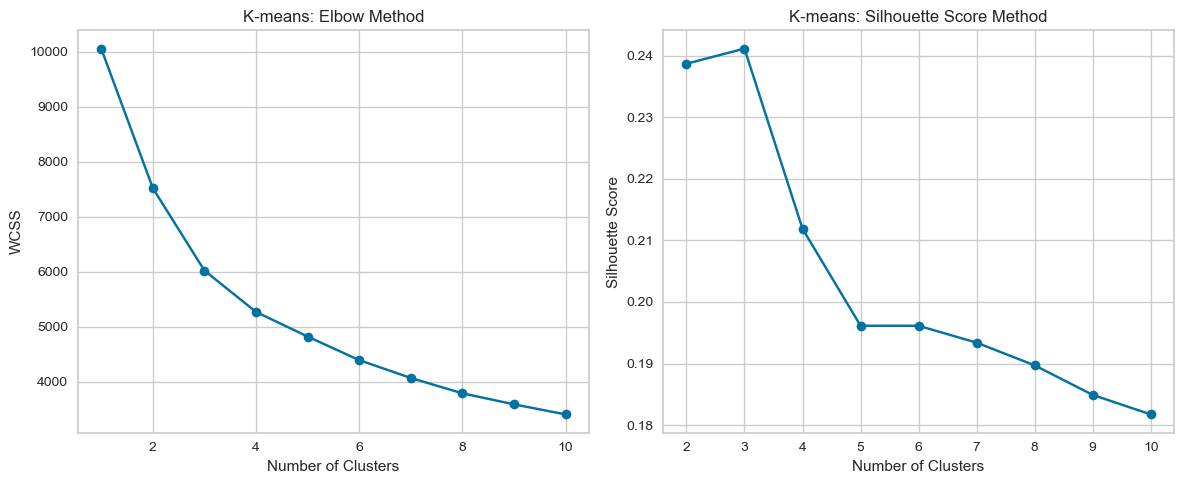

In [26]:
#K-Means

#WCSS Elbow method
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss, marker='o')
plt.title('K-means: Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True) 

#Silhouette Score
plt.subplot(1, 2, 2)
silhouette_scores_kmeans = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=42)
    cluster_labels = kmeans.fit_predict(X_pca)
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    silhouette_scores_kmeans.append(silhouette_avg)
    print(f'K-means - Clusters: {i}, Silhouette Score: {silhouette_avg:.4f}')
plt.plot(range(2, 11), silhouette_scores_kmeans, marker='o')
plt.title('K-means: Silhouette Score Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.tight_layout()
plt.show()

K-means Silhouette Score: 0.3577
K-means Calinski-Harabasz Score: 2705.16


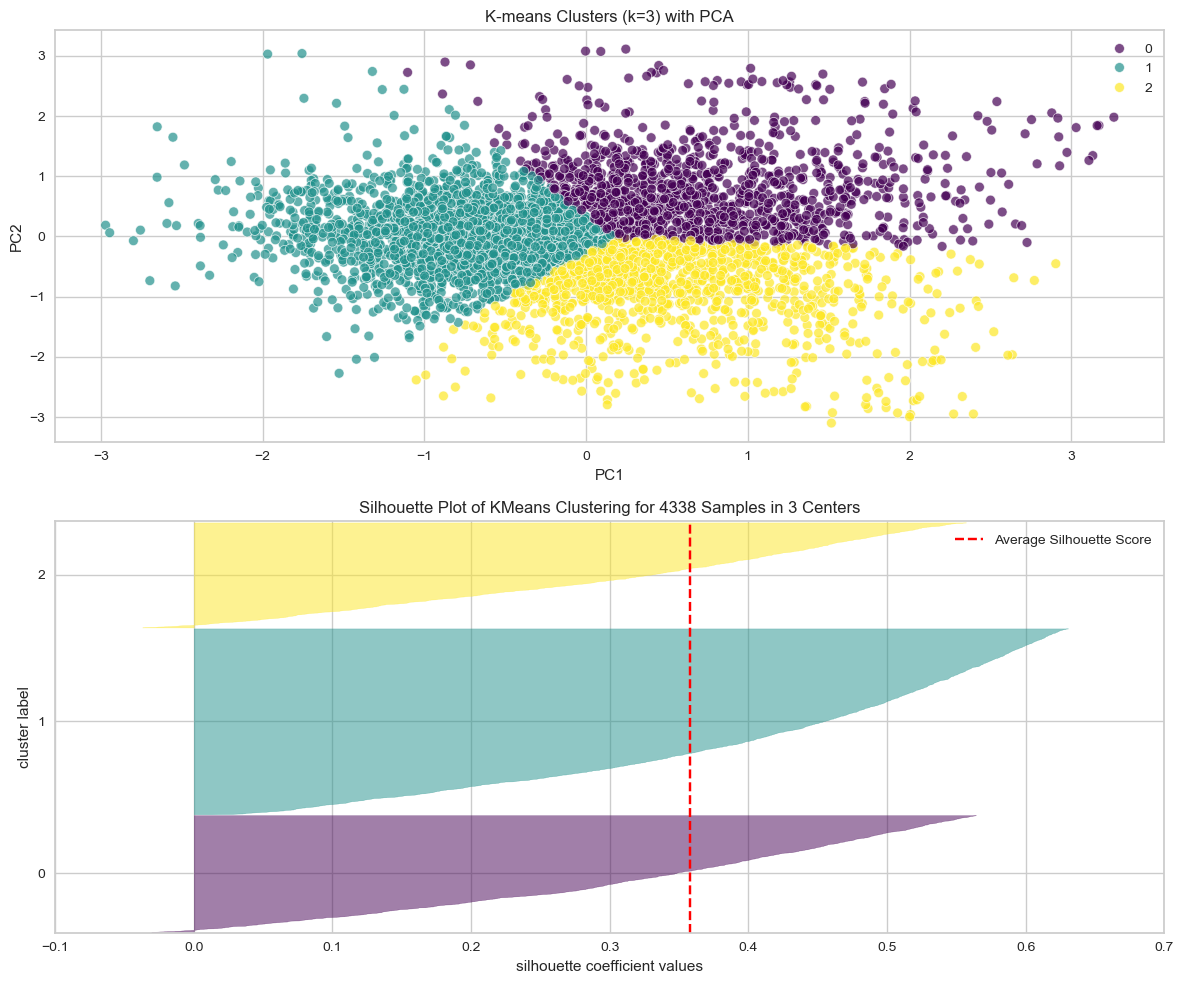

In [56]:
#Optimal number of clusters for K-means
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', n_init=10, random_state=42)
kmeans_labels = kmeans.fit_predict(X_pca)

#Calculate evaluation metrics
kmeans_silhouette = silhouette_score(X_pca, kmeans_labels)
kmeans_ch_score = calinski_harabasz_score(X_pca, kmeans_labels)
print(f'K-means Silhouette Score: {kmeans_silhouette:.4f}')
print(f'K-means Calinski-Harabasz Score: {kmeans_ch_score:.2f}')

#K-means visualization with PCA
plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_labels, palette='viridis', s=50, alpha=0.7)
plt.title(f'K-means Clusters (k={optimal_k}) with PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')

#Silhouette Visualization
plt.subplot(2, 1, 2)
visualizer = SilhouetteVisualizer(kmeans, colors='viridis')
visualizer.fit(X_pca)
visualizer.finalize()
plt.tight_layout()
plt.show()

#### a2. Hierarchal Clustering

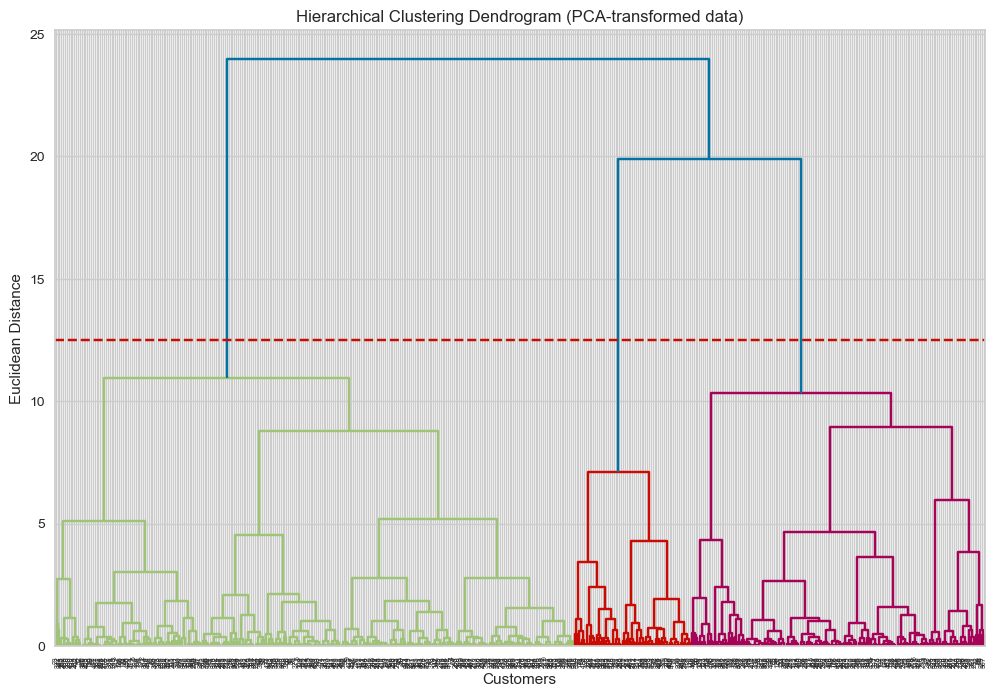

In [57]:
#Hierarchal clustering

#Create dendrogram 
plt.figure(figsize=(12, 8))
X_pca_df = pd.DataFrame(X_pca)
sample_data = X_pca_df.sample(500) if len(X_pca_df) > 500 else X_pca_df
dendrogram = shc.dendrogram(shc.linkage(sample_data, method='ward'))
plt.title('Hierarchical Clustering Dendrogram (PCA-transformed data)')
plt.xlabel('Customers')
plt.ylabel('Euclidean Distance')
plt.axhline(y=12.5, color='r', linestyle='--')  
plt.show()

Hierarchical - Clusters: 2, Silhouette Score: 0.3132
Hierarchical - Clusters: 3, Silhouette Score: 0.3330
Hierarchical - Clusters: 4, Silhouette Score: 0.2653
Hierarchical - Clusters: 5, Silhouette Score: 0.2488
Hierarchical - Clusters: 6, Silhouette Score: 0.2613
Hierarchical - Clusters: 7, Silhouette Score: 0.2303
Hierarchical - Clusters: 8, Silhouette Score: 0.2366
Hierarchical - Clusters: 9, Silhouette Score: 0.2437
Hierarchical - Clusters: 10, Silhouette Score: 0.2583


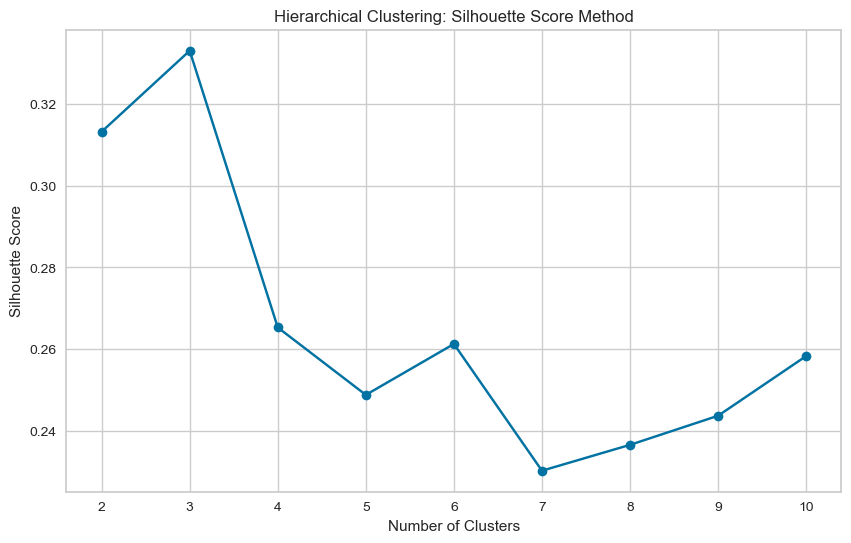

In [58]:
#Testing number of clusters
silhouette_scores_hc = []
for i in range(2, 11):
    hc = AgglomerativeClustering(n_clusters=i, linkage='ward')
    hc_labels = hc.fit_predict(X_pca)
    silhouette_avg = silhouette_score(X_pca, hc_labels)
    silhouette_scores_hc.append(silhouette_avg)
    print(f'Hierarchical - Clusters: {i}, Silhouette Score: {silhouette_avg:.4f}')

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores_hc, marker='o')
plt.title('Hierarchical Clustering: Silhouette Score Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

Hierarchical Clustering - Silhouette Score: 0.3330
Hierarchical Clustering - Calinski-Harabasz Score: 2143.07


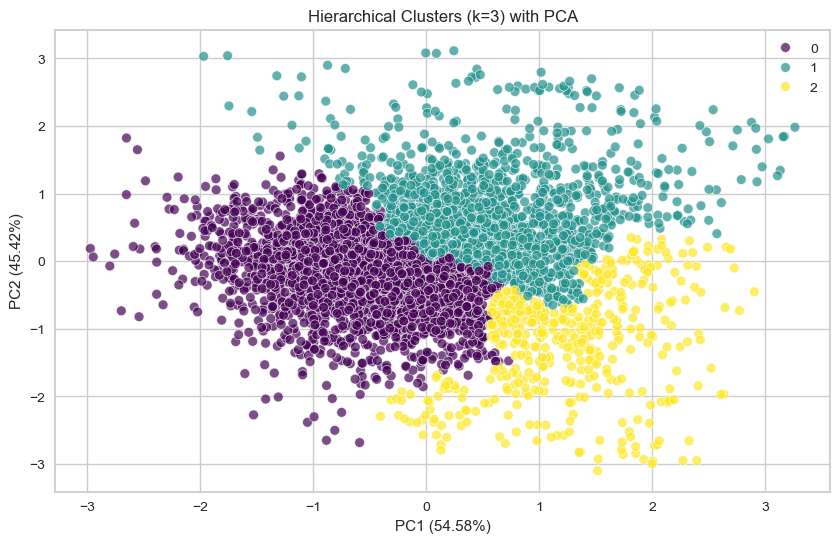

In [59]:
#Optimal number of clusters 
optimal_hc = 3
hc = AgglomerativeClustering(n_clusters=optimal_hc, linkage='ward')
hc_labels = hc.fit_predict(X_pca)

#Calculate performance metrics
hc_silhouette = silhouette_score(X_pca, hc_labels)
hc_ch_score = calinski_harabasz_score(X_pca, hc_labels)
print(f"Hierarchical Clustering - Silhouette Score: {hc_silhouette:.4f}")
print(f"Hierarchical Clustering - Calinski-Harabasz Score: {hc_ch_score:.2f}")

#Visualize
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_pca)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=hc_labels, palette='viridis', s=50, alpha=0.7)
plt.title(f'Hierarchical Clusters (k={optimal_hc}) with PCA')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
plt.show()


#### a3. DBSCAN Clustering

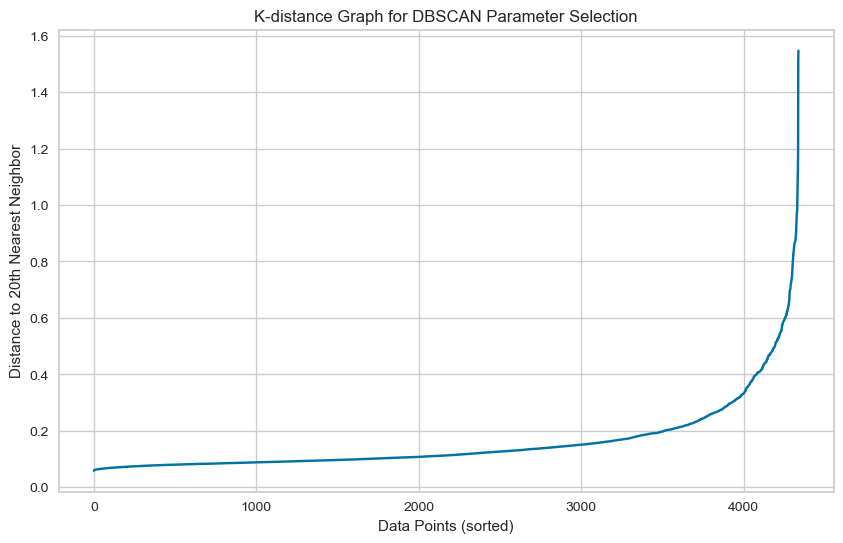

In [60]:
#Find optimal eps value
neighbors = NearestNeighbors(n_neighbors=20)
neighbors_fit = neighbors.fit(X_pca)
distances, indices = neighbors_fit.kneighbors(X_pca)

distances = np.sort(distances[:, 19]) 

#Plot K-distance 
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('K-distance Graph for DBSCAN Parameter Selection')
plt.xlabel('Data Points (sorted)')
plt.ylabel('Distance to 20th Nearest Neighbor')
plt.grid(True)
plt.show()

In [61]:
#Test best eps values
eps_values = [0.3, 0.35, 0.4, 0.45, 0.5]
min_samples_values = [3, 5, 7, 10, 15, 20]

best_silhouette = -1
best_params = None
best_n_clusters = 0

#Grid search for DBSCAN parameters
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(X_pca)
        
        #Skip configurations with only noise points (-1) or just one cluster
        n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
        if n_clusters <= 2:
            continue
            
        #Calculate silhouette score (only on non-noise points)
        if -1 in dbscan_labels:
            mask = dbscan_labels != -1
            if sum(mask) > 1:  
                silhouette_avg = silhouette_score(X_pca[mask], dbscan_labels[mask])
            else:
                continue
        else:
            silhouette_avg = silhouette_score(X_pca, dbscan_labels)
            
        print(f'DBSCAN - eps: {eps}, min_samples: {min_samples}, Clusters: {n_clusters}, Silhouette: {silhouette_avg:.4f}')
        
        if silhouette_avg > best_silhouette:
            best_silhouette = silhouette_avg
            best_params = (eps, min_samples)
            best_n_clusters = n_clusters

print(f'\nBest DBSCAN parameters: eps={best_params[0]}, min_samples={best_params[1]}')
print(f'Number of clusters: {best_n_clusters}')
print(f'Silhouette score: {best_silhouette:.4f}')

DBSCAN - eps: 0.3, min_samples: 3, Clusters: 3, Silhouette: 0.2954
DBSCAN - eps: 0.3, min_samples: 5, Clusters: 5, Silhouette: 0.2983
DBSCAN - eps: 0.3, min_samples: 10, Clusters: 5, Silhouette: 0.3320
DBSCAN - eps: 0.35, min_samples: 15, Clusters: 3, Silhouette: 0.4056

Best DBSCAN parameters: eps=0.35, min_samples=15
Number of clusters: 3
Silhouette score: 0.4056


Percentage of noise points: 2.67%
DBSCAN Silhouette Score: 0.4056
DBSCAN Calinski-Harabasz Score: 155.19


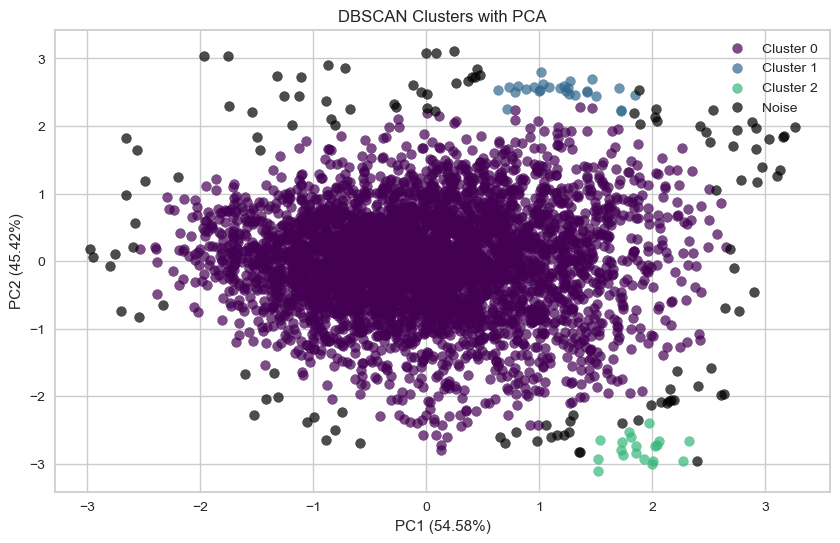

In [62]:
#Apply DBSCAN with the best parameters
dbscan = DBSCAN(eps=best_params[0], min_samples=best_params[1])
dbscan_labels = dbscan.fit_predict(X_pca)

#Calculate percentage of noise points
noise_percentage = np.sum(dbscan_labels == -1) / len(dbscan_labels) * 100
print(f'Percentage of noise points: {noise_percentage:.2f}%')

#Calculate DBSCAN metrics 
if len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0) > 1:
    mask = dbscan_labels != -1
    if sum(mask) > 1:
        dbscan_silhouette = silhouette_score(X_pca[mask], dbscan_labels[mask])
        dbscan_ch_score = calinski_harabasz_score(X_pca[mask], dbscan_labels[mask])
        print(f'DBSCAN Silhouette Score: {dbscan_silhouette:.4f}')
        print(f'DBSCAN Calinski-Harabasz Score: {dbscan_ch_score:.2f}')
    else:
        dbscan_silhouette = 'N/A'
        dbscan_ch_score = 'N/A'
else:
    dbscan_silhouette = 'N/A'
    dbscan_ch_score = 'N/A'


#DBSCAN visualization with PCA
plt.figure(figsize=(10, 6))
unique_labels = set(dbscan_labels) #diff color for noise
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))

for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]
    
    mask = dbscan_labels == k
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], color=col, 
                s=50, alpha=0.7, label=f'Cluster {k}' if k != -1 else 'Noise')

plt.title('DBSCAN Clusters with PCA')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
plt.legend()
plt.show()

#### b. Model Comparison

In [63]:
#Create a comparison table
comparison_data = {
    'Algorithm': ['K-means', 'Hierarchical', 'DBSCAN'],
    'Optimal Clusters': [optimal_k, optimal_hc, best_n_clusters],
    'Silhouette Score': [kmeans_silhouette, hc_silhouette, dbscan_silhouette],
    'Calinski-Harabasz Score': [kmeans_ch_score, hc_ch_score, dbscan_ch_score],
}

comparison_df = pd.DataFrame(comparison_data)
print('Model Comparison:')
display(comparison_df)

customer_features['cluster_kmeans'] = kmeans_labels
customer_features['cluster_hierarchical'] = hc_labels
customer_features['cluster_dbscan'] = dbscan_labels

Model Comparison:


,Algorithm,Optimal Clusters,Silhouette Score,Calinski-Harabasz Score
0,K-means,3,0.357699,2705.160839
1,Hierarchical,3,0.332999,2143.074360
2,DBSCAN,3,0.405579,155.188028


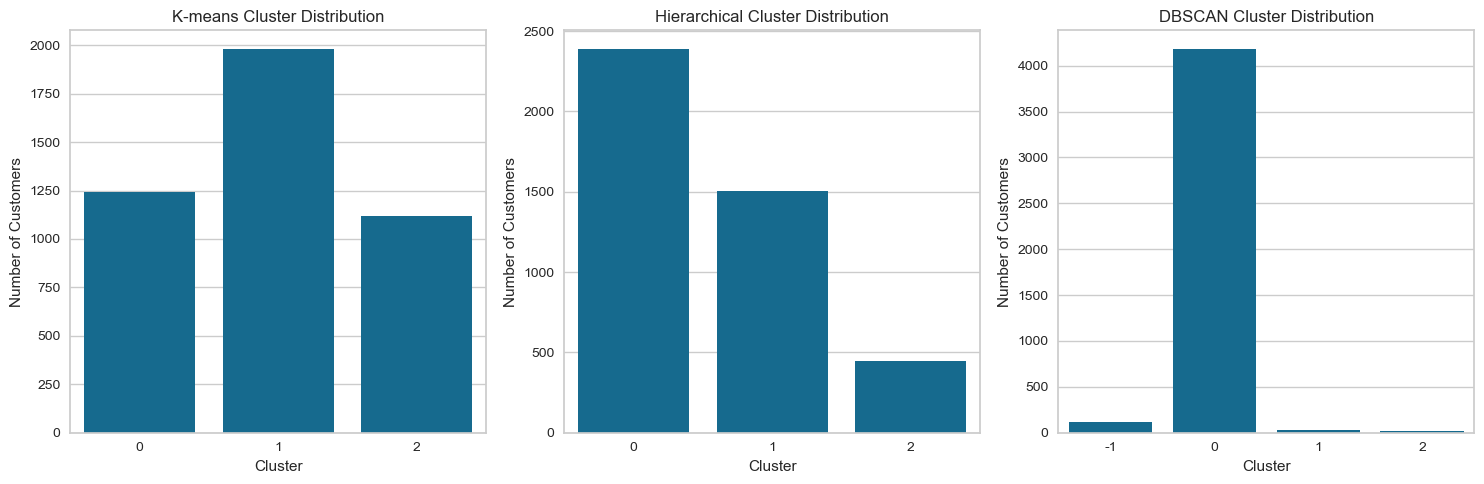

In [64]:
#Visualize the distribution of customers
plt.figure(figsize=(15, 5))

#K-means clusters
plt.subplot(1, 3, 1)
sns.countplot(x='cluster_kmeans', data=customer_features)
plt.title('K-means Cluster Distribution')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')

#Hierarchical clusters
plt.subplot(1, 3, 2)
sns.countplot(x='cluster_hierarchical', data=customer_features)
plt.title('Hierarchical Cluster Distribution')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')

#DBSCAN clusters
plt.subplot(1, 3, 3)
sns.countplot(x='cluster_dbscan', data=customer_features)
plt.title('DBSCAN Cluster Distribution')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')

plt.tight_layout()
plt.show()

### III. Model Interpretation

In [65]:
#Analyze profiles of each cluster for K-means
kmeans_profiles = customer_features.groupby('cluster_kmeans').agg({
    'Recency': 'mean',
    'Purchase_Frequency': 'mean',
    'Avg_Spend_per_Order': 'mean',
    'UnitPrice_mean': 'mean',
    'StockCode_nunique': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Count'})

kmeans_profiles = kmeans_profiles.reset_index()

print('Cluster Profiles (K-means):')
display(kmeans_profiles)

Cluster Profiles (K-means):


,cluster_kmeans,Recency,Purchase_Frequency,Avg_Spend_per_Order,UnitPrice_mean,StockCode_nunique,Count
0,0,147.530596,2.393720,278.397221,9.092798,21.159420,1242
1,1,44.911021,6.569767,588.202776,2.980703,106.530334,1978
2,2,111.822898,2.293381,270.583863,1.972570,26.650268,1118


In [66]:
#Analyze profiles of each cluster for Hierarchical Clustering
hierarchical_profiles = customer_features.groupby('cluster_hierarchical').agg({
    'Recency': 'mean',
    'Purchase_Frequency': 'mean',
    'Avg_Spend_per_Order': 'mean',
    'UnitPrice_mean': 'mean',
    'StockCode_nunique': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Count'})

hierarchical_profiles = hierarchical_profiles.reset_index()

print('Cluster Profiles (Hierarchical Clustering):')
display(hierarchical_profiles)

Cluster Profiles (Hierarchical Clustering):


,cluster_hierarchical,Recency,Purchase_Frequency,Avg_Spend_per_Order,UnitPrice_mean,StockCode_nunique,Count
0,0,51.826415,5.855765,539.326544,2.608113,93.568553,2385
1,1,138.289509,2.521912,309.436910,8.195184,25.503320,1506
2,2,145.894855,1.718121,132.978536,1.861571,11.684564,447


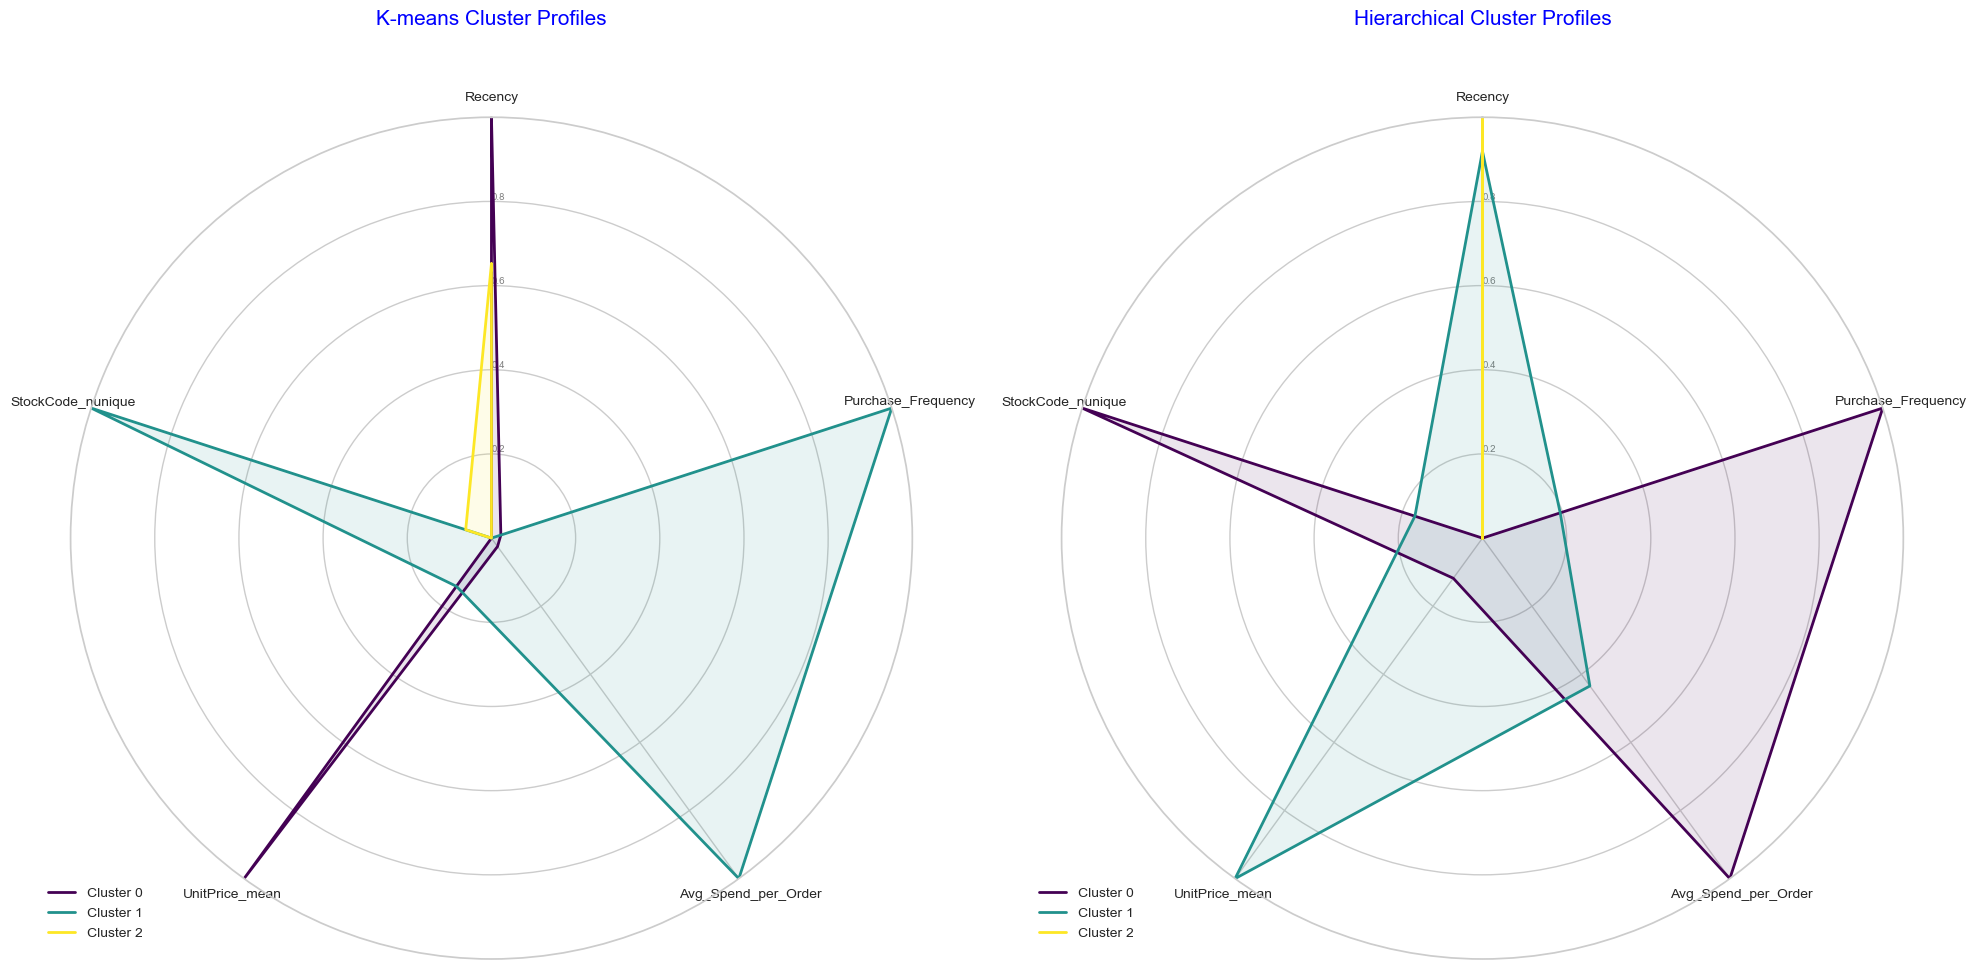

In [67]:
# Cluster profiles visualization - K-means vs Hierarchical radar charts
features = ['Recency', 'Purchase_Frequency', 'Avg_Spend_per_Order', 'UnitPrice_mean', 'StockCode_nunique']
N = len(features)

#Create normalized dataframes for radar charts
radar_kmeans = kmeans_profiles[features].copy()
for feature in features:
    radar_kmeans[feature] = (radar_kmeans[feature] - radar_kmeans[feature].min()) / (radar_kmeans[feature].max() - radar_kmeans[feature].min())

radar_hierarchical = hierarchical_profiles[features].copy()
for feature in features:
    radar_hierarchical[feature] = (radar_hierarchical[feature] - radar_hierarchical[feature].min()) / (radar_hierarchical[feature].max() - radar_hierarchical[feature].min())

#Create angles for radar chart
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # Close the loop

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), subplot_kw=dict(polar=True))

cmap = plt.cm.viridis
kmeans_colors = cmap(np.linspace(0, 1, len(radar_kmeans)))
hc_colors = cmap(np.linspace(0, 1, len(radar_hierarchical)))

#Plot K-means radar chart
for i, cluster in enumerate(radar_kmeans.index):
    values = radar_kmeans.loc[cluster].values.tolist()
    values += values[:1] 
    
    ax1.plot(angles, values, linewidth=2, linestyle='solid', 
             label=f'Cluster {cluster}', color=kmeans_colors[i])
    ax1.fill(angles, values, alpha=0.1, color=kmeans_colors[i])

ax1.set_theta_offset(pi / 2)
ax1.set_theta_direction(-1)
ax1.set_xticks(angles[:-1])
ax1.set_xticklabels(features)
ax1.set_rlabel_position(0)
ax1.set_yticks([0.2, 0.4, 0.6, 0.8])
ax1.set_yticklabels(["0.2", "0.4", "0.6", "0.8"], color="grey", size=7)
ax1.set_ylim(0, 1)
ax1.set_title("K-means Cluster Profiles", size=15, color='blue', y=1.1)
ax1.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

#Plot Hierarchical radar chart
for i, cluster in enumerate(radar_hierarchical.index):
    values = radar_hierarchical.loc[cluster].values.tolist()
    values += values[:1]  
    
    ax2.plot(angles, values, linewidth=2, linestyle='solid', 
             label=f'Cluster {cluster}', color=hc_colors[i])
    ax2.fill(angles, values, alpha=0.1, color=hc_colors[i])

ax2.set_theta_offset(pi / 2)
ax2.set_theta_direction(-1)
ax2.set_xticks(angles[:-1])
ax2.set_xticklabels(features)
ax2.set_rlabel_position(0)
ax2.set_yticks([0.2, 0.4, 0.6, 0.8])
ax2.set_yticklabels(["0.2", "0.4", "0.6", "0.8"], color="grey", size=7)
ax2.set_ylim(0, 1)
ax2.set_title("Hierarchical Cluster Profiles", size=15, color='blue', y=1.1)
ax2.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.tight_layout()
plt.savefig('kmeans_vs_hierarchical_radar.png', dpi=300, bbox_inches='tight')
plt.show()

In [68]:
#Create a tabular comparison for the two clustering methods
print('Cluster Size Comparison - K-means vs Hierarchical:')
cluster_sizes = pd.DataFrame({
    'K-means': kmeans_profiles['Count'],
    'Hierarchical': hierarchical_profiles['Count']
})
display(cluster_sizes)

#Calculate similarity between clustering methods (Normalized Mutual Information)
from sklearn.metrics import normalized_mutual_info_score

nmi = normalized_mutual_info_score(
    customer_features['cluster_kmeans'], 
    customer_features['cluster_hierarchical']
)

print(f'\nClustering Similarity (Normalized Mutual Information): {nmi:.4f}')
print('(0 = completely different clusters, 1 = identical clusters)')

# Create cross-tabulation of clusters
print('\nCluster Overlap (Cross-tabulation):')
cluster_cross = pd.crosstab(
    customer_features['cluster_kmeans'], 
    customer_features['cluster_hierarchical'],
    rownames=['K-means'], 
    colnames=['Hierarchical']
)
display(cluster_cross)

#Check proportion of maximum overlap
total_customers = len(customer_features)
max_overlap = cluster_cross.max(axis=1).sum()
stability = max_overlap / total_customers

print(f'\nCluster stability (higher = more similar assignments): {stability:.2%}')

Cluster Size Comparison - K-means vs Hierarchical:


,K-means,Hierarchical
0,1242,2385
1,1978,1506
2,1118,447



Clustering Similarity (Normalized Mutual Information): 0.4871
(0 = completely different clusters, 1 = identical clusters)

Cluster Overlap (Cross-tabulation):


Hierarchical,0,1,2
K-means,,,
0,8,1190,44
1,1789,189,0
2,588,127,403



Cluster stability (higher = more similar assignments): 82.23%


In [69]:
#Comparing scores

print(f'Score Comparison:')
display(comparison_df)

if kmeans_silhouette > hc_silhouette:
    better_silhouette = "K-means"
else:
    better_silhouette = "Hierarchical"
    
if kmeans_ch_score > hc_ch_score:
    better_ch = "K-means"
else:
    better_ch = "Hierarchical"

print('Decision Summary:')
print(f'Better Silhouette Score: {better_silhouette}')
print(f'Better Calinski-Harabasz Score: {better_ch}')

# Overall recommendation
if (kmeans_silhouette > hc_silhouette and kmeans_ch_score > hc_ch_score):
    recommendation = "K-means"
elif (hc_silhouette > kmeans_silhouette and hc_ch_score > kmeans_ch_score):
    recommendation = "Hierarchical"
else:
    #If metrics disagree, check silhouette
    recommendation = "K-means" if kmeans_silhouette > hc_silhouette else "Hierarchical"
    recommendation += " (metrics show mixed results)"

print(f'\nRecommended algorithm: {recommendation}')


Score Comparison:


,Algorithm,Optimal Clusters,Silhouette Score,Calinski-Harabasz Score
0,K-means,3,0.357699,2705.160839
1,Hierarchical,3,0.332999,2143.074360
2,DBSCAN,3,0.405579,155.188028


Decision Summary:
Better Silhouette Score: K-means
Better Calinski-Harabasz Score: K-means

Recommended algorithm: K-means
